In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil, sklearn

from modules import WineDb
from modules.PreprocessingFunctions import Functions as prep

if os.path.exists('modules\__pycache__'):
    shutil.rmtree('modules\__pycache__')

In [2]:
winedb = WineDb.WineDb()
winedb().describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


# Binary Classification

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Train/Test/Split and fit auxiliary functions
def get_split_data(input_db, excluded, target, test_size=0.33):
    np.random.seed(42)
    
    excluded_col = excluded+target
    x = input_db.loc[:,input_db.columns.difference(excluded_col)]
    y = input_db.loc[:,target][target[0]]
    
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.4, random_state = 42)
    
    return x_train, x_test, y_train, y_test

def fit_and_test(args, model, input_db):
    np.random.seed(42)
    
    x_train, x_test, y_train, y_test = args
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    accuracy = sklearn.metrics.accuracy_score(y_test, pred)
    
    return {'modelname':str(model),
            'input_db':input_db,
            'accuracy':accuracy,
            'sensitivity':tp/(tp+fn),
            'specificity':tn/(tn+fp)}

In [4]:
# Pipelines
def pipeline1_class_1(x, target, excluded):
    x = prep.isoforest_outliers(x, target+excluded)
    x = prep.minmax_norm(x, target+excluded)
    return x

def pipeline_class_2(x, target, excluded):
    x = prep.isoforest_outliers(x, target+excluded)
    x = prep.pca(x, target+excluded)
    return x

def pipeline_class_3(x, target, excluded):
    x = prep.smote(x)
    x = prep.minmax_norm(x, target+excluded)
    return x



In [5]:
target_col = ['type']
excluded_col = ['alcohol', 'quality']

dbs = {
    'benchmark': winedb(),
    'zscore_out': prep.zscore_outliers(winedb(), 3, target_col+excluded_col),
    'isoforest_out': prep.isoforest_outliers(winedb(), target_col+excluded_col),
    'minmax_norm': prep.minmax_norm(winedb(), target_col+excluded_col),
    'standard_norm': prep.standard_norm(winedb(), target_col+excluded_col),
    'pca': prep.pca(winedb(), target_col+excluded_col),
    'smote': prep.smote(winedb()),
    'random_undersample': prep.random_undersample(winedb()),
    'pipeline_1': pipeline1_class_1(winedb(), target_col, excluded_col),
    'pipeline_2': pipeline_class_2(winedb(), target_col, excluded_col),
    'pipeline_3': pipeline_class_3(winedb(), target_col, excluded_col)
       }


Random Forest Results

In [6]:
classifiers = [RandomForestClassifier(), KNeighborsClassifier()]

res_class = []

for dbname in dbs:
    for model in classifiers:
        res_class.append(fit_and_test(get_split_data(dbs[dbname], excluded_col, target_col), model, dbname))
        
res_class = pd.DataFrame(res_class)


In [7]:
res_class.sort_values(['modelname', 'accuracy'], ascending = [True, False])

,modelname,input_db,accuracy,sensitivity,specificity
17,KNeighborsClassifier(),pipeline_1,0.994080,0.981238,0.997817
21,KNeighborsClassifier(),pipeline_3,0.991069,0.992904,0.989209
9,KNeighborsClassifier(),standard_norm,0.990381,0.977876,0.994794
7,KNeighborsClassifier(),minmax_norm,0.988842,0.977876,0.992712
5,KNeighborsClassifier(),isoforest_out,0.941748,0.796296,0.984691
1,KNeighborsClassifier(),benchmark,0.930743,0.802360,0.976054
11,KNeighborsClassifier(),pca,0.930743,0.802360,0.976054
13,KNeighborsClassifier(),smote,0.929064,0.956412,0.901336
3,KNeighborsClassifier(),zscore_out,0.925541,0.773897,0.969892
15,KNeighborsClassifier(),random_undersample,0.898438,0.883200,0.912977


In [8]:
res_class.sort_values(['modelname', 'accuracy'], ascending = [True, False]).round(decimals=3).to_csv('results_classification.csv')

# Regression (and SVM)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [10]:
# Pipelines
def pipeline_reg_1(x, target, excluded):
    x = prep.isoforest_outliers(x, target+excluded)
    x = prep.minmax_norm(x, target+excluded)
    return x

def pipeline_reg_2(x, target, excluded):
    x = prep.isoforest_outliers(x, target+excluded)
    x = prep.pca(x, target+excluded)
    return x

def pipeline_reg_3(x, target, excluded):
    x = prep.minmax_norm(x, target+excluded)
    x = prep.pca(x, target+excluded)
    return x

In [11]:
# NOTE: no need to do sampling for the regression as the type column is ignored anyway

target_col = ['quality']
excluded_col = ['type']

dbs = {
    'benchmark': winedb(),
    'zscore_out': prep.zscore_outliers(winedb(), 3, target_col+excluded_col),
    'isoforest_out': prep.isoforest_outliers(winedb(), target_col+excluded_col),
    'minmax_norm': prep.minmax_norm(winedb(), target_col+excluded_col),
    'standard_norm': prep.standard_norm(winedb(), target_col+excluded_col),
    'pca': prep.pca(winedb(), target_col+excluded_col),
    'pipeline_1': pipeline_reg_1(winedb(), target_col, excluded_col),
    'pipeline_2': pipeline_reg_2(winedb(), target_col, excluded_col),
    'pipeline_3': pipeline_reg_3(winedb(), target_col, excluded_col)
       }


In [12]:
def test_regressors(regressor, regressor_name, input_db, dbname):
    np.random.seed(42)
    
    x_train, x_test, y_train, y_test = get_split_data(input_db, [], ['quality'])
    
    regressor.fit(x_train, y_train)
    preds = regressor.predict(x_test)
    cross_val_scores = cross_val_score(regressor, x_train, y_train, scoring="neg_mean_absolute_percentage_error")
    mse = mean_squared_error(y_test, preds)
    
    return({'name':regressor_name.upper(),
            'pipeline':dbname, 
            'r2_score':regressor.score(x_test, y_test),
            'mse':mse})

In [13]:
regressors = {'linear':LinearRegression(),
              #'BayesianRidge':BayesianRidge(),
              'SVM_rbf':SVR(kernel='rbf'),
              #'adaboost':AdaBoostRegressor()
              }

res_reg = []

for dbname in dbs:
    for modelname in regressors:
        res_reg.append(test_regressors(regressors[modelname], modelname, dbs[dbname], dbname))
    
res_reg = pd.DataFrame(res_reg)

f:\Desktop\MML\.venv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
f:\Desktop\MML\.venv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
f:\Desktop\MML\.venv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
f:\Desktop\MML\.venv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
f:\Desktop\MML\.venv\lib\site-packages\sklea

In [14]:
res_reg.sort_values(['name', 'r2_score'], ascending = [True, False])

,name,pipeline,r2_score,mse
4,LINEAR,isoforest_out,0.290739,0.546424
2,LINEAR,zscore_out,0.290069,0.513637
0,LINEAR,benchmark,0.280279,0.540076
8,LINEAR,standard_norm,0.280279,0.540076
6,LINEAR,minmax_norm,0.280279,0.540076
12,LINEAR,pipeline_1,0.275692,0.524809
10,LINEAR,pca,0.275196,0.543890
16,LINEAR,pipeline_3,0.275149,0.543926
14,LINEAR,pipeline_2,0.011432,0.756222
9,SVM_RBF,standard_norm,0.377279,0.467288


In [15]:
res_reg.sort_values(['name', 'r2_score'], ascending = [True, False]).round(decimals=3).to_csv('results_regression.csv')

In [16]:
np.random.seed(42)


x_train, x_test, y_train, y_test = get_split_data(dbs['standard_norm'], [], ['quality'])
regressors['SVM_rbf'].fit(x_train, y_train)

preds = regressors['SVM_rbf'].predict(x_test)

In [19]:
regressors['SVM_rbf'].score(x_test, y_test)

0.37727917673997513

<AxesSubplot: >

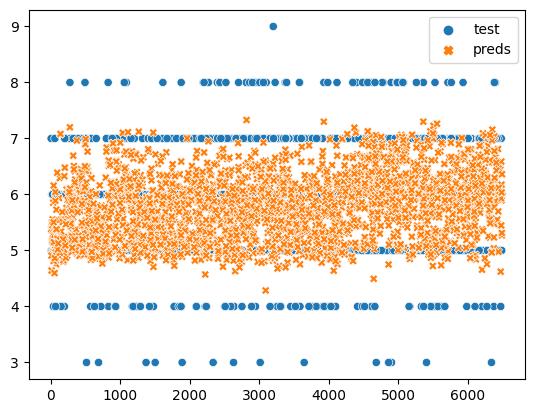

In [20]:
data = pd.DataFrame()
data['test'] = y_test
data['preds'] = preds
sns.scatterplot(data=data)